## L3_timeseries solution

### Bartłomiej Pukacki 151942

#### Imports

In [1]:
import os
from dotenv import load_dotenv

from datetime import timedelta

from pathlib import Path

import pandas as pd
import numpy as np

import torch
import matplotlib.pyplot as plt

from utils151942 import plot_seasonal_decomposition, plot_consumption, TimeSeriesExperiment

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [4]:
torch.set_float32_matmul_precision('medium')

c:\Users\Bartek\anaconda3\envs\ai\Lib\site-packages\torch\__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


In [5]:
# %wandb login

#### Data Read and Cleanup

In [6]:
DATA_PATH = Path("data/TS0277.csv.gz")
# DATA_PATH = Path("../data/TS4011.csv.gz")

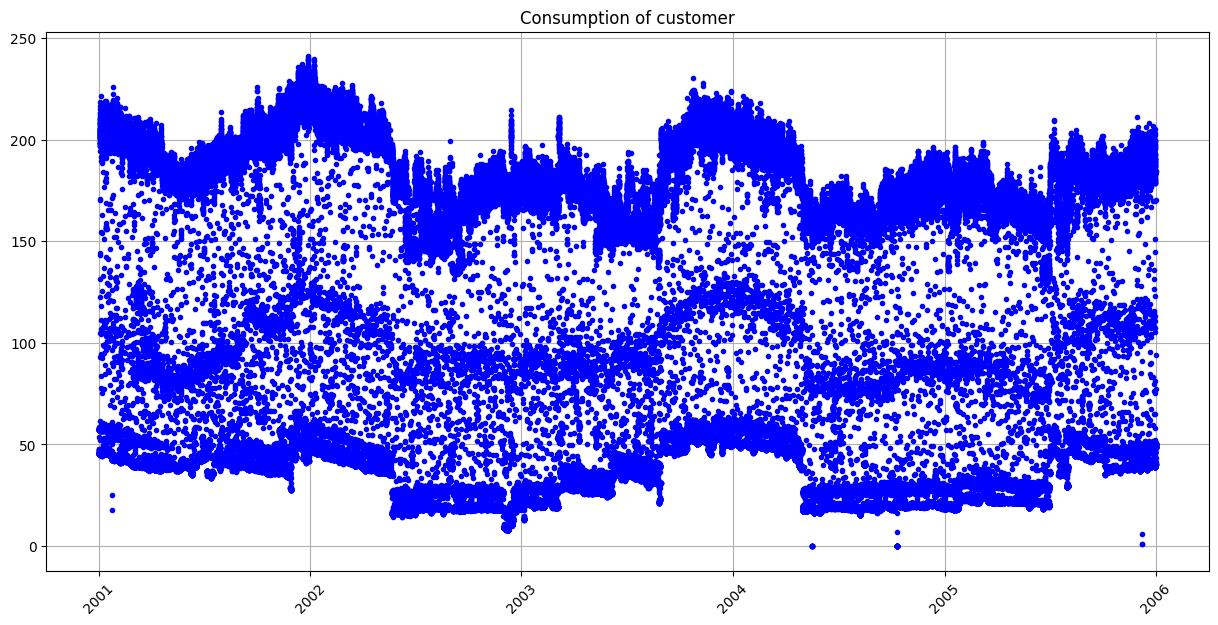

In [7]:
plt.figure(figsize=(15, 7))
df = pd.read_csv(DATA_PATH, header=None)
df.columns = ['time', 'value']
df['time'] = pd.to_datetime(df['time'])
plt.plot(df['time'], df['value'], 'b.')
plt.title('Consumption of customer')
plt.xticks(rotation=45) 
plt.grid()
plt.show()

In [8]:
duplicates = df[df.duplicated('time', keep=False)]
df.shape, duplicates.shape

((175296, 2), (40, 2))

In [9]:
df = df.drop_duplicates(subset='time', keep='last')
df.shape

(175276, 2)

Some unexpected time duplicates are found with possibly slightly different values. Will assume that keeping the last measurement is correct

In [10]:
start_time = pd.Timestamp('2001-01-01 00:00:00')
end_time = df['time'].max()
expected_index = pd.date_range(start=start_time, end=end_time, freq='15min')

actual_times = pd.DatetimeIndex(df['time'])
missing_times = expected_index.difference(actual_times)

In [11]:
missing_times.shape

(20,)

Some timesteps are missing, I will fill them with last available value

In [12]:
# df_old = df

In [13]:
df = df.set_index("time").reindex(expected_index)
df.index.name = "time"
df['value'] = df['value'].ffill()
df.head()

,value
time,
2001-01-01 00:00:00,46.15
2001-01-01 00:15:00,45.65
2001-01-01 00:30:00,46.05
2001-01-01 00:45:00,45.80
2001-01-01 01:00:00,47.60


In [14]:
df.loc[pd.Timestamp('2001-03-25 01:45:00'), 'value'], df.loc[pd.Timestamp('2001-03-25 02:00:00'), 'value']

(np.float64(38.6), np.float64(38.6))

In [15]:
df['value'].isna().sum()

np.int64(0)

In [16]:
### Sanity check for misplaced timestamp values

# comparison = df.loc[df_old['time']]
# merged = pd.DataFrame({
#     'original': df_old['value'].values,
#     'filled': comparison['value'].values
# })

# # Check for mismatches
# differences = merged[merged['original'] != merged['filled']]
# differences.shape

In [17]:
pd.infer_freq(df.index)

'15min'

#### Seasonal Decomposition

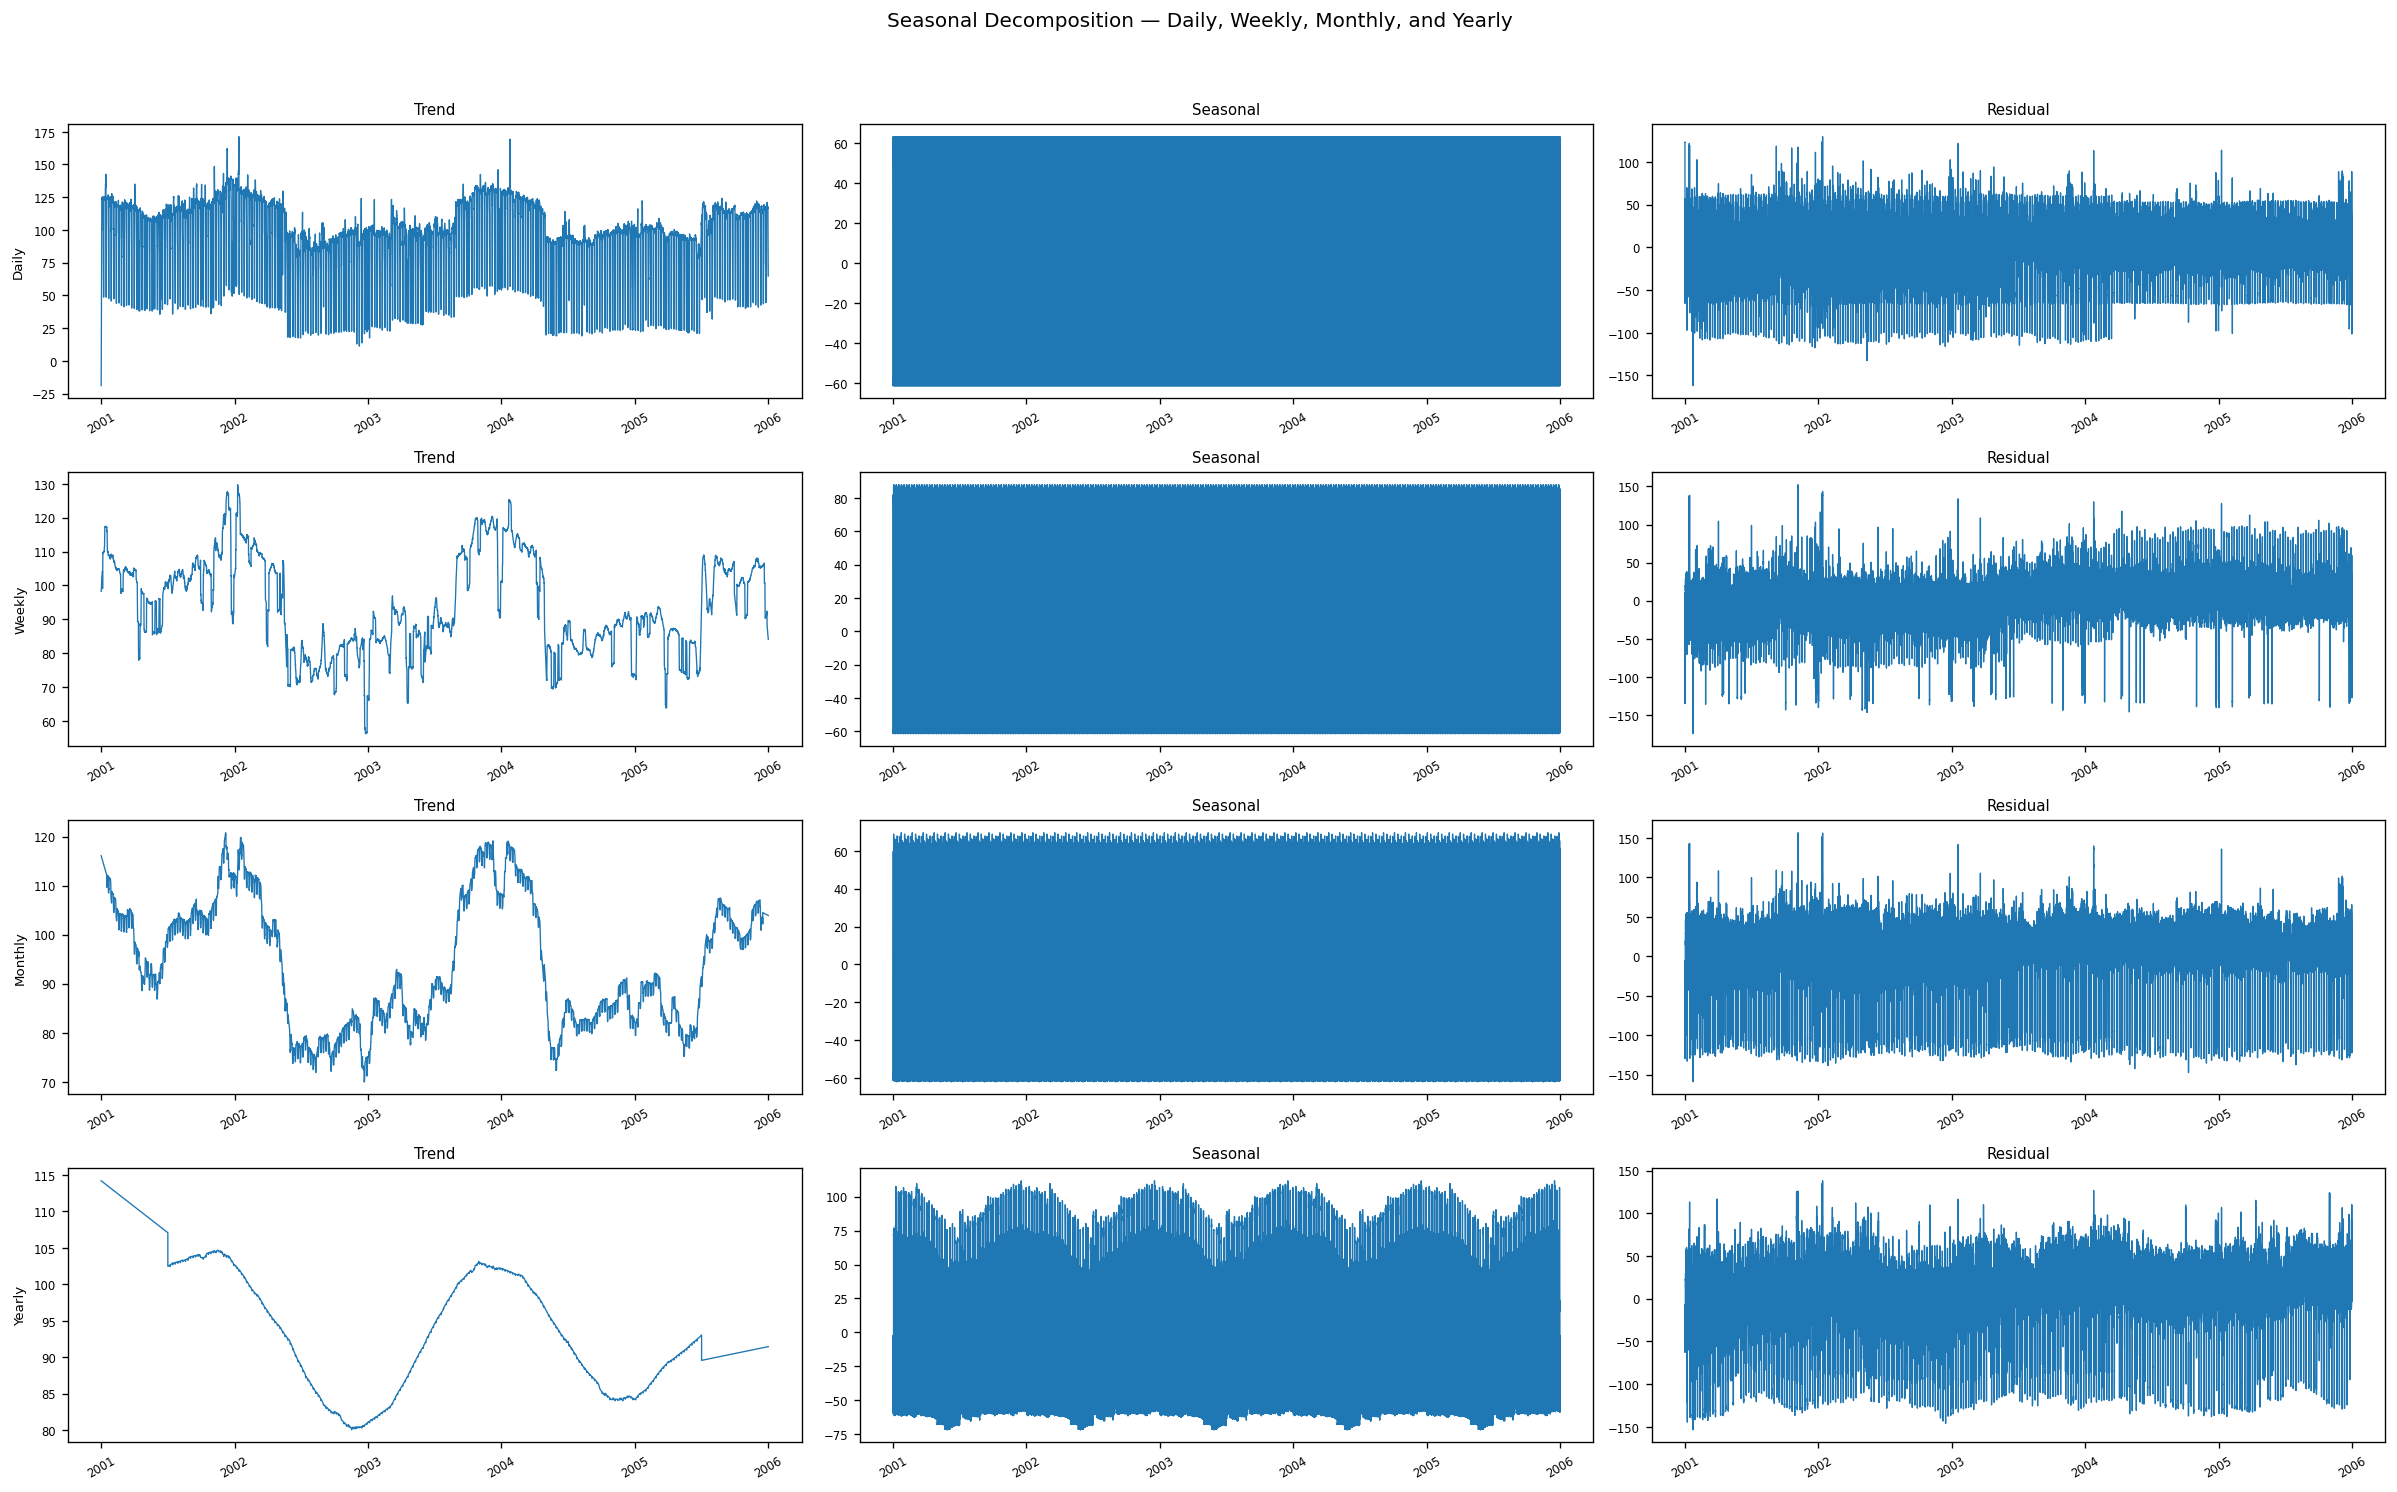

In [18]:
plot_seasonal_decomposition(df)

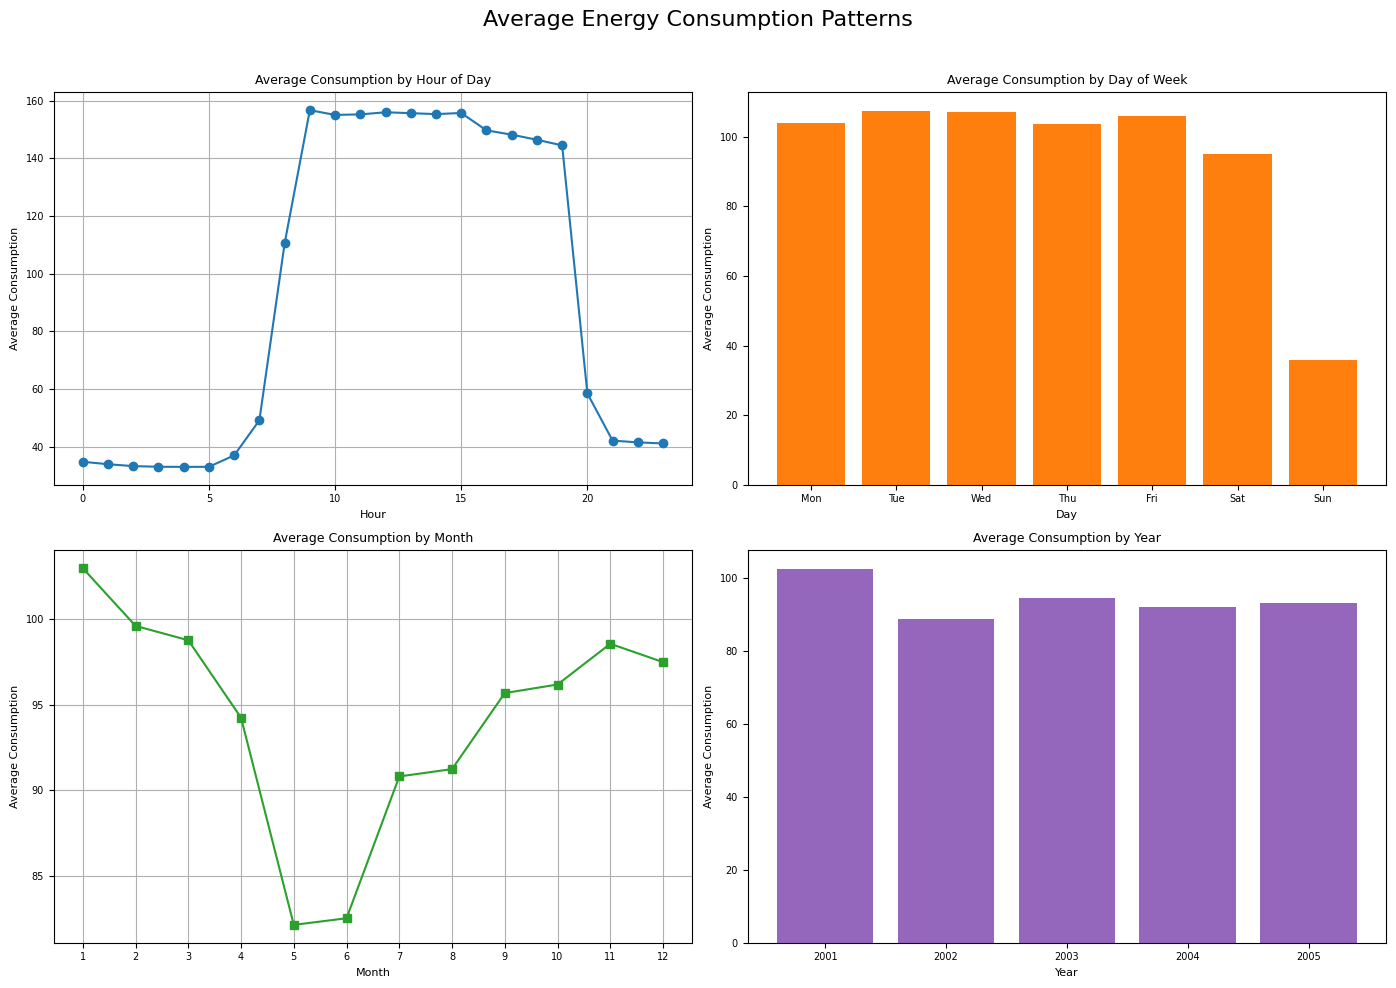

In [19]:
plot_consumption(df)

##### Observations

The seasonal decomposition makes it possible to see the overall trend in yearly consumption while the seasonal and residual components are difficult to interpret suggesting complexity of data and existence of noise. When plotting average consumption by hour of day, a clear trend of high energy consumption during daylight hours (6-21) can be observed. During colder months the energy consumption is also higher as would be expected. Lastly, average consumption is significantly lower on sunday in the case of this customer.  

#### Scale with Average Consumption

In [20]:
avg_consumption = df['value'].mean()
std_consumption = df['value'].std()
df['scaled_value'] = (df['value'] - avg_consumption) / std_consumption

#### Dynamic Data Experiments

In [21]:
df = df.sort_index()

In [22]:
print(f"\n{'='*60}")
print("Running hyperparameter optimization")
print(f"{'='*60}\n")

experiment = TimeSeriesExperiment(
    df=df,
    value_column='scaled_value',
    seq_length=96*7,
    pred_length=96,  # 1 day ahead
    batch_size=128,
    wandb_project="timeseries-base_lstm-optimization",
    wandb_entity="bpukacki-poznan-university-of-technology"
)

best_params = experiment.optimize_hyperparameters(n_trials=10, max_epochs=20)

[I 2025-11-16 10:25:30,943] A new study created in memory with name: no-name-5b14e1d8-62fa-4506-8770-0bd50690f576
c:\Users\Bartek\Desktop\Studies\masters\semII\MLOps-PUT\project1\utils151942.py:371: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Running hyperparameter optimization



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bpukacki (bpukacki-poznan-university-of-technology). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 928    | train
1 | fc   | Linear | 864    | train
----------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K   


Best hyperparameters:
  hidden_size: 16
  learning_rate: 0.005157021608399238

Best validation loss: 0.2877


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 3.4 K  | train
1 | fc   | Linear | 1.6 K  | train
----------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.283


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.260


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.254


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.252


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.252. Signaling Trainer to stop.
Restoring states from the checkpoint path at .\timeseries-base_lstm-optimization\8jyb4kxt\checkpoints\best-epoch=06-val_loss=0.2521.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\timeseries-base_lstm-optimization\8jyb4kxt\checkpoints\best-epoch=06-val_loss=0.2521.ckpt
c:\Users\Bartek\anaconda3\envs\ai\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28876280784606934
        test_mae            0.3147566318511963
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


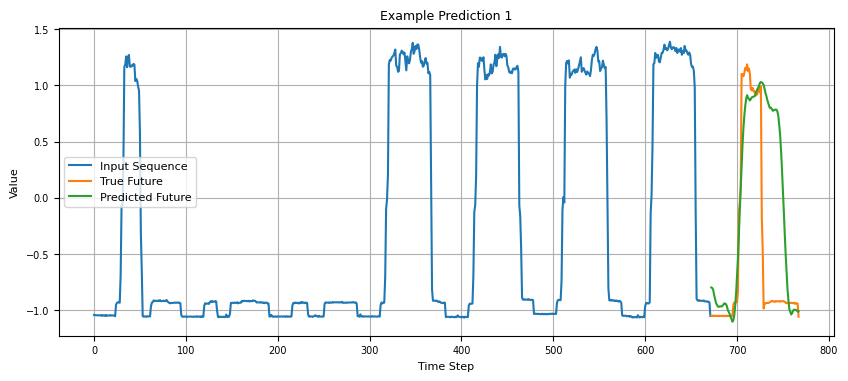

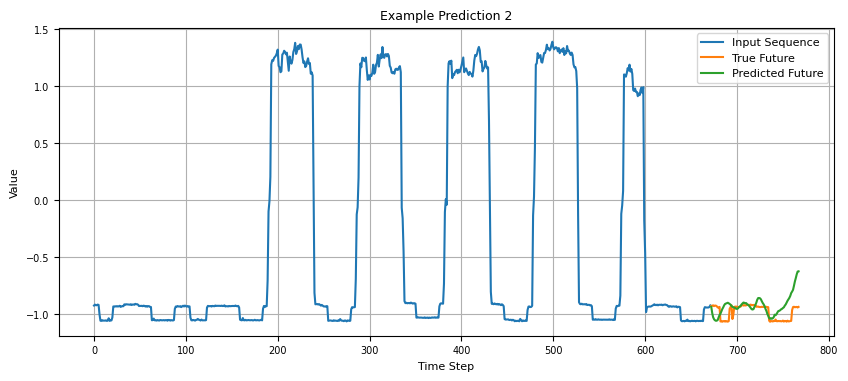

In [23]:
final_model, final_trainer = experiment.train_model(
    **best_params,
    max_epochs=100,
    experiment_name="lstm_optimized"
)

experiment.plot_predictions(final_model, n_examples=2)